In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta


data = pd.read_csv('BTCUSDT_1m.csv')
data.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore'],
      dtype='object')


--- Momentum Alpha Performance ---
Total Return: -365.4066
Annualized Return: -0.0252
Sharpe Ratio: -16.2001
Sortino Ratio: -20.8474
Max Drawdown: -1.0000
Trade Frequency: 248.7054
Hit Ratio: 0.0011


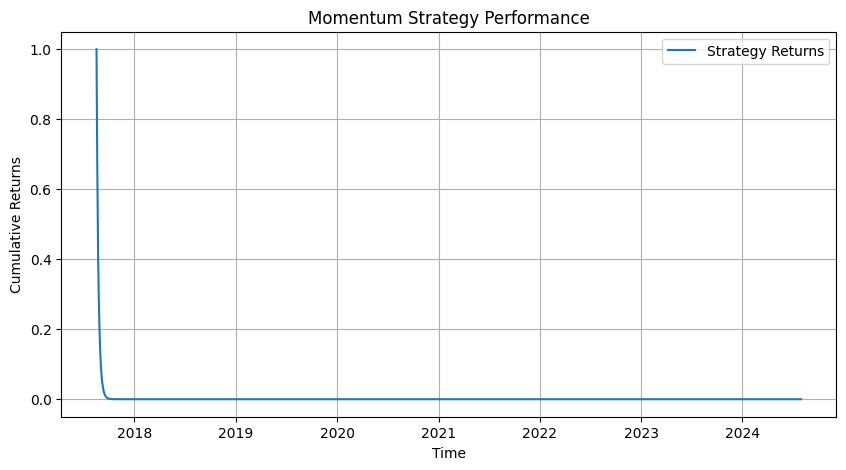


--- Volatility Alpha Performance ---
Total Return: -364.1483
Annualized Return: -0.0252
Sharpe Ratio: -15.3949
Sortino Ratio: -23.1327
Max Drawdown: -1.0000
Trade Frequency: 515.7410
Hit Ratio: 0.0044


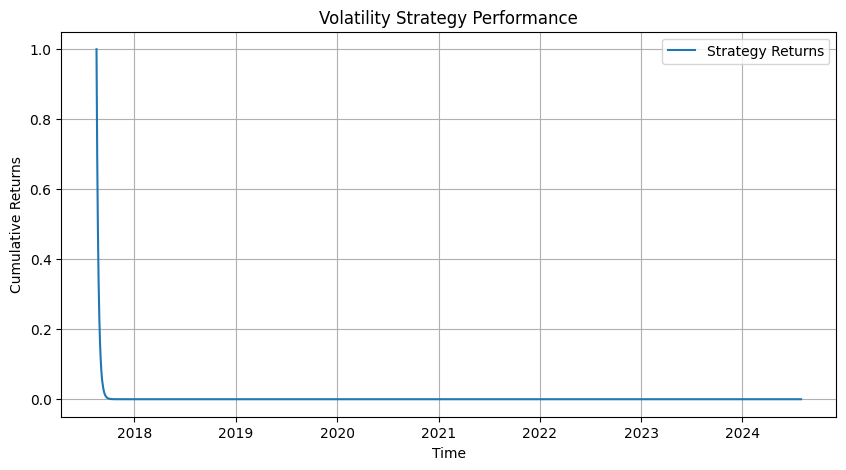


--- Mean-Reversion Alpha Performance ---
Total Return: -364.3078
Annualized Return: -0.0252
Sharpe Ratio: -24.5098
Sortino Ratio: -38.9268
Max Drawdown: -1.0000
Trade Frequency: 237.2342
Hit Ratio: 0.0009


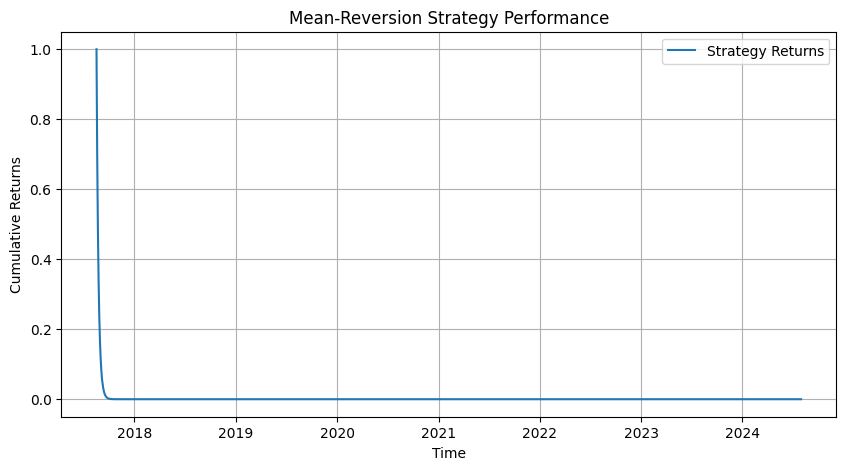

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


transaction_cost = 0.00005
slippage = 0.00005

def calculate_max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def backtest_alpha(data, alpha_func, transaction_cost=transaction_cost, slippage=slippage):
    data = data.copy()
    
    
    data['signal'] = alpha_func(data)
    data['signal'] = data['signal'] / np.abs(data['signal']).max()

    
    data['signal'] = np.where(data['signal'].abs() > 0.1, data['signal'], 0)
    
    
    data['volatility'] = data['close'].pct_change().rolling(window=20).std()
    data['position'] = data['signal'] * (1 / (1 + 5 * data['volatility']))
    data['position'] = data['position'].clip(-1, 1)  


    data['position'] = np.where(data['position'] != 0, data['position'], 0)
    data['position'] = data['position'].shift(1).where(data['position'] == 0, data['position'])

    
    data['strategy_returns'] = data['close'].pct_change() * data['position'].shift(1)
    data['net_returns'] = data['strategy_returns'] - transaction_cost - slippage

    
    total_return = data['net_returns'].sum()
    annualized_return = data['net_returns'].mean() * 252
    sharpe_ratio = data['net_returns'].mean() / data['net_returns'].std() * np.sqrt(252) if data['net_returns'].std() != 0 else 0
    sortino_ratio = data['net_returns'].mean() / data[data['net_returns'] < 0]['net_returns'].std() * np.sqrt(252) if data[data['net_returns'] < 0]['net_returns'].std() != 0 else 0
    max_drawdown = calculate_max_drawdown((1 + data['net_returns']).cumprod())

    
    trades = data['position'].diff().fillna(0).abs().sum() / 2
    hit_ratio = (data['net_returns'] > 0).mean()

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Trade Frequency": trades,
        "Hit Ratio": hit_ratio
    }, data


def alpha_momentum(data, lookback=20):
    return data['close'].pct_change(lookback)

def alpha_volatility(data, lookback=20):
    return data['close'].rolling(lookback).std()

def alpha_mean_reversion(data, lookback=20):
    return -(data['close'] - data['close'].rolling(lookback).mean())


def plot_performance(data, title="Strategy Performance"):
    cumulative_returns = (1 + data['net_returns']).cumprod()
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_returns, label='Strategy Returns')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()
    plt.show()


data = pd.read_csv('BTCUSDT_1m.csv')  


data['timestamp'] = pd.to_datetime(data['timestamp'])


data.set_index('timestamp', inplace=True)


alpha_functions = {
    "Momentum": alpha_momentum,
    "Volatility": alpha_volatility,
    "Mean-Reversion": alpha_mean_reversion,
}

alpha_results = {}
for alpha_name, alpha_func in alpha_functions.items():
    results, backtest_data = backtest_alpha(data.copy(), alpha_func)
    alpha_results[alpha_name] = results

    print(f"\n--- {alpha_name} Alpha Performance ---")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

  
    plot_performance(backtest_data, title=f"{alpha_name} Strategy Performance")

Data Quality Check:
Missing values:
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
ignore                          0
dtype: int64
Data types:
open                            float64
high                            float64
low                             float64
close                           float64
volume                          float64
close_time                        int64
quote_asset_volume              float64
number_of_trades                  int64
taker_buy_base_asset_volume     float64
taker_buy_quote_asset_volume    float64
ignore                            int64
dtype: object
First few rows:
                        open     high      low    close    volume  \
timestamp                 

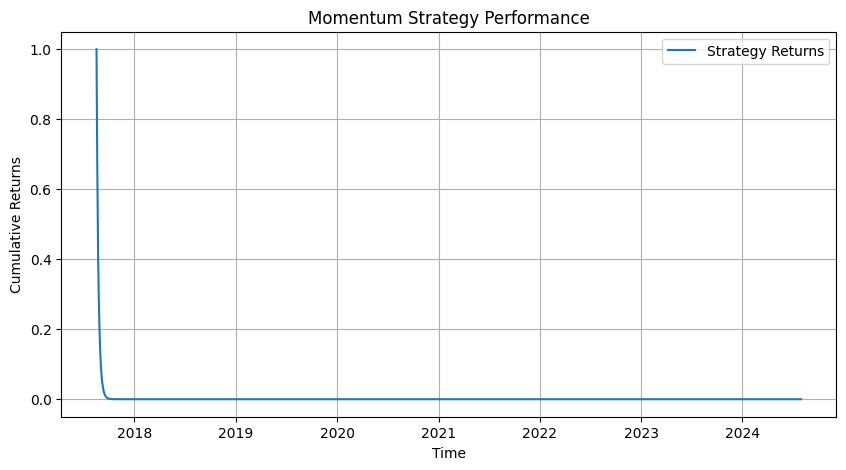


--- Volatility Alpha Performance ---
Total Return: -364.1483
Annualized Return: -0.0252
Sharpe Ratio: -15.3949
Sortino Ratio: -23.1327
Max Drawdown: -1.0000
Trade Frequency: 515.7410
Hit Ratio: 0.0044


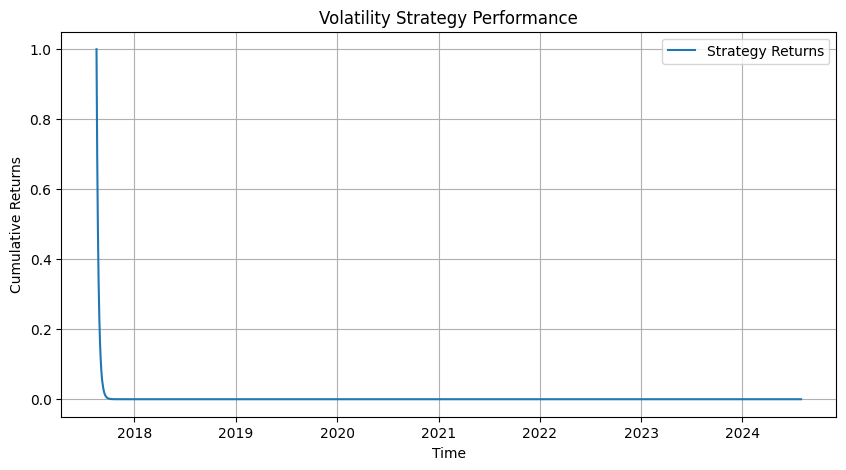


--- Mean-Reversion Alpha Performance ---
Total Return: -364.3078
Annualized Return: -0.0252
Sharpe Ratio: -24.5098
Sortino Ratio: -38.9268
Max Drawdown: -1.0000
Trade Frequency: 237.2342
Hit Ratio: 0.0009


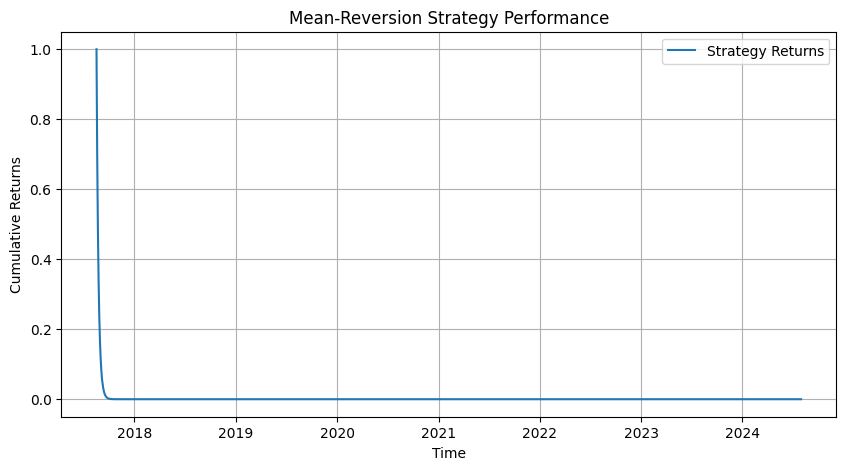


--- Combined Alpha Performance ---
Total Return: -364.7267
Annualized Return: -0.0252
Sharpe Ratio: -2856906768421200.0000
Sortino Ratio: -2856906768421200.0000
Max Drawdown: -1.0000
Trade Frequency: 0.0000
Hit Ratio: 0.0000


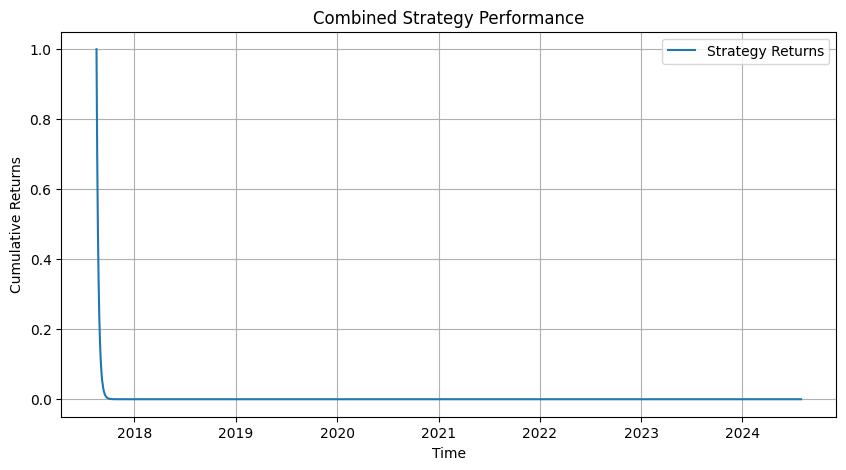

In [5]:

def check_data_quality(data):
    print("Data Quality Check:")
    print(f"Missing values:\n{data.isnull().sum()}")
    print(f"Data types:\n{data.dtypes}")
    print(f"First few rows:\n{data.head()}")


check_data_quality(data)


def alpha_combined(data, lookback=20):
    momentum_signal = data['close'].pct_change(lookback)
    volatility_signal = data['close'].rolling(lookback).std()
    combined_signal = momentum_signal / volatility_signal  
    return combined_signal


alpha_functions['Combined'] = alpha_combined

alpha_results = {}
for alpha_name, alpha_func in alpha_functions.items():
    results, backtest_data = backtest_alpha(data.copy(), alpha_func)
    alpha_results[alpha_name] = results
   
    print(f"\n--- {alpha_name} Alpha Performance ---")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")


    plot_performance(backtest_data, title=f"{alpha_name} Strategy Performance")


--- Combined Alpha Performance ---
Total Return: -364.3732
Annualized Return: -0.0252
Sharpe Ratio: -31.0271
Sortino Ratio: -50.2201
Max Drawdown: -1.0000
Trade Frequency: 85.1434
Hit Ratio: 0.0006


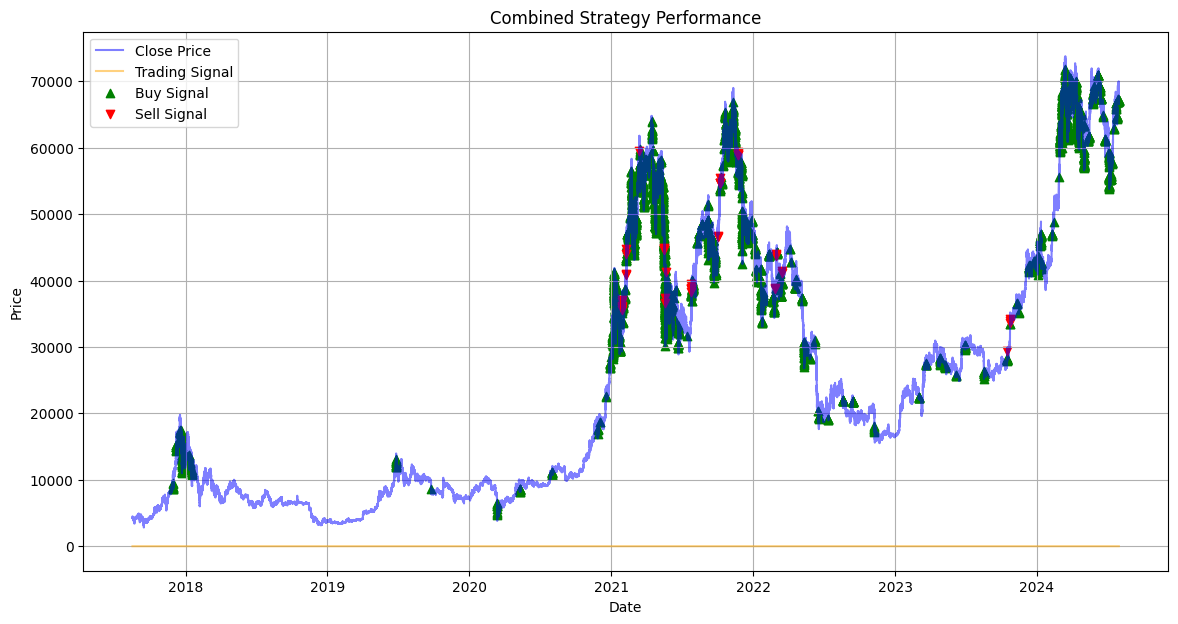

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


transaction_cost = 0.00005
slippage = 0.00005

def backtest_alpha(data, alpha_funcs, transaction_cost=transaction_cost, slippage=slippage):
    data = data.copy()
    

    signals = np.zeros(data.shape[0])
    for alpha_func in alpha_funcs:
        signals += alpha_func(data)
    
    
    signals /= np.abs(signals).max()
    
 
    data['signal'] = signals
    data['signal'] = data['signal'].rolling(window=5).mean()  
    
    data['signal'] = np.where(data['signal'].abs() > 0.1, data['signal'], 0)
    
    
    data['volatility'] = data['close'].pct_change().rolling(window=20).std()
    data['position'] = data['signal'] * (1 / (1 + 5 * data['volatility']))
    data['position'] = data['position'].clip(-1, 1)  

    data['strategy_returns'] = data['close'].pct_change() * data['position'].shift(1)
    data['net_returns'] = data['strategy_returns'] - transaction_cost - slippage

  
    total_return = data['net_returns'].sum()
    annualized_return = data['net_returns'].mean() * 252
    sharpe_ratio = data['net_returns'].mean() / data['net_returns'].std() * np.sqrt(252) if data['net_returns'].std() > 0 else 0
    sortino_ratio = data['net_returns'].mean() / data[data['net_returns'] < 0]['net_returns'].std() * np.sqrt(252) if data[data['net_returns'] < 0]['net_returns'].std() > 0 else 0
    max_drawdown = calculate_max_drawdown((1 + data['net_returns']).cumprod())


    trades = data['position'].diff().fillna(0).abs().sum() / 2
    hit_ratio = (data['net_returns'] > 0).mean()

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Trade Frequency": trades,
        "Hit Ratio": hit_ratio
    }, data

def calculate_max_drawdown(cum_returns):
   
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()


def alpha_momentum(data, lookback=20):
    return data['close'].pct_change(lookback)

def alpha_volatility(data, lookback=20):
    return data['close'].rolling(lookback).std()

def alpha_mean_reversion(data, lookback=20):
    return -(data['close'] - data['close'].rolling(lookback).mean())

def plot_strategy(data, title="Strategy Performance"):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['close'], label='Close Price', color='blue', alpha=0.5)
    plt.plot(data.index, data['signal'], label='Trading Signal', color='orange', alpha=0.5)
    
   
    buy_signals = data[data['signal'] > 0]
    sell_signals = data[data['signal'] < 0]
    plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal', alpha=1)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


alpha_functions = [alpha_momentum, alpha_volatility, alpha_mean_reversion]

alpha_results = {}
results, backtest_data = backtest_alpha(data.copy(), alpha_functions)
alpha_results["Combined"] = results


print(f"\n--- Combined Alpha Performance ---")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


plot_strategy(backtest_data, title="Combined Strategy Performance")